In [1]:
# Import de Bibliotecas necessárias
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
import numpy as np
import os

In [2]:
# Configurações gerais para os gráficos
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
sns.set_style("whitegrid")

# Caminho do arquivo CSV e diretório de saída para os gráficos
file_path = 'estadosmunicipios2024\\EstadosMunicipios2023\\Municipal - Diagnostico.csv'
output_dir = 'graphs'

# Carregar os dados
df = pd.read_csv(file_path, sep=';', encoding='utf-8', on_bad_lines='warn')

# Renomear colunas para facilitar o acesso
df = df.rename(columns={
    'UF Declarante': 'UF',
    'Possui Coleta Seletiva Implantada': 'Coleta Seletiva',
    'Caracterização - Destinação': 'Destinacao',
    'Caracterização - Destinação percentual': 'Percentual Destinacao',
    'Possui Plano de Gestão': 'Plano de Gestao',
    'Caracterização - Descrição': 'Tipo Resíduo'
})

# Remover espaços em branco nas colunas categóricas relevantes
df['Coleta Seletiva'] = df['Coleta Seletiva'].str.strip()
df['Plano de Gestao'] = df['Plano de Gestao'].str.strip()
df['Tipo Resíduo'] = df['Tipo Resíduo'].str.strip()

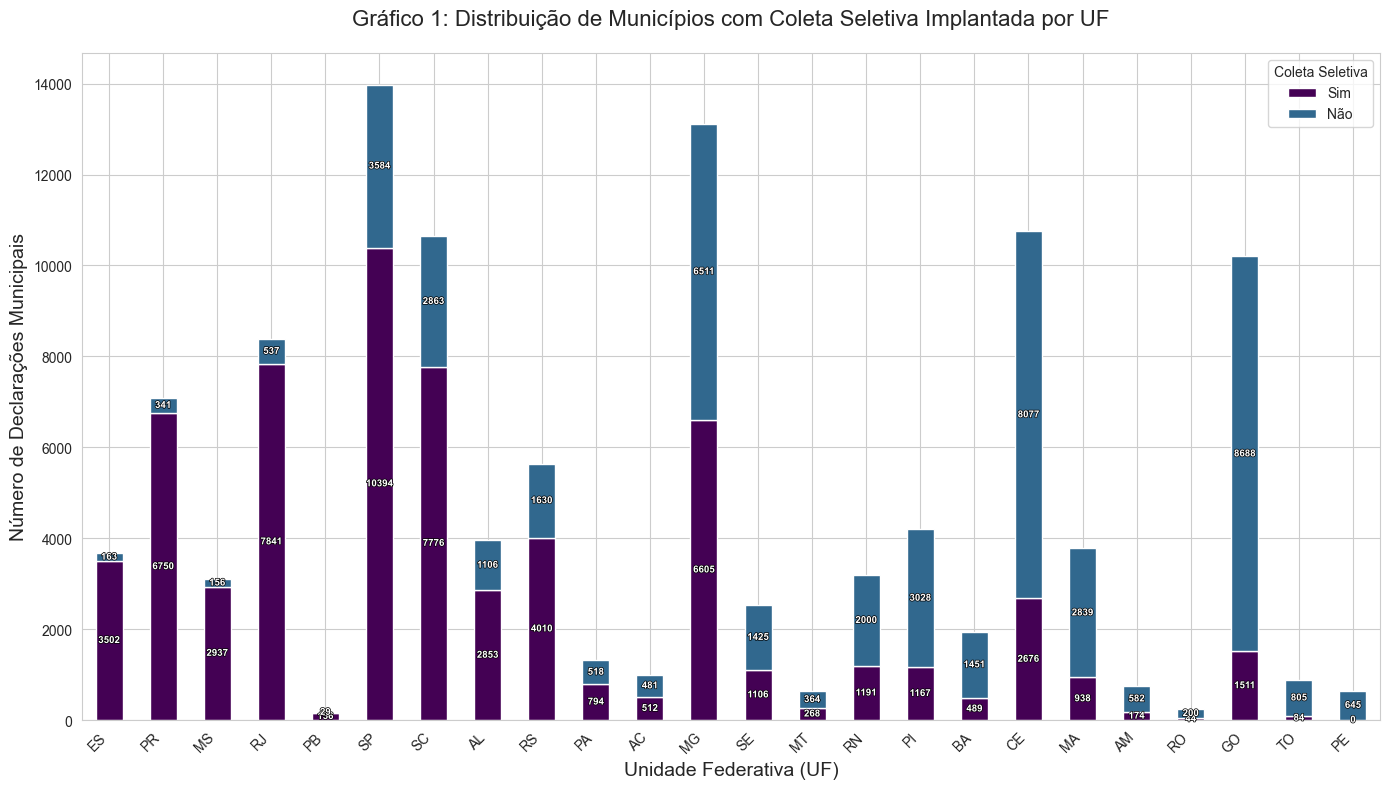

In [3]:
# Gráfico 1: Distribuição de Municípios com Coleta Seletiva Implantada por UF

# ACálculo de proporções e agrupamento por UF
coleta_seletiva_uf = df.groupby('UF')['Coleta Seletiva'].value_counts(normalize=False).unstack(fill_value=0)
coleta_seletiva_uf['Total'] = coleta_seletiva_uf.sum(axis=1)
coleta_seletiva_uf['Proporcao Sim'] = coleta_seletiva_uf['Sim'] / coleta_seletiva_uf['Total']
coleta_seletiva_uf = coleta_seletiva_uf.sort_values(by='Proporcao Sim', ascending=False)

# Plota
plt.figure(figsize=(14, 8))
ax = coleta_seletiva_uf[['Sim', 'Não']].plot(
    kind='bar', 
    stacked=True, 
    color=['#440154', '#31688E'], 
    ax=plt.gca()
)

# Adicionando valores vísiveis nas barras
for i in range(len(coleta_seletiva_uf)):
    sim_count = coleta_seletiva_uf['Sim'].iloc[i]
    nao_count = coleta_seletiva_uf['Não'].iloc[i]
    
    ax.text(i, sim_count / 2, str(sim_count), ha='center', va='center', color='white', fontsize=7, fontweight='bold', path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=1, foreground='black')])
    ax.text(i, sim_count + (nao_count / 2), str(nao_count), ha='center', va='center', color='white', fontsize=7, fontweight='bold', path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=1, foreground='black')])

# Títulos e formatação
plt.title('Gráfico 1: Distribuição de Municípios com Coleta Seletiva Implantada por UF', fontsize=16, pad=20)
plt.xlabel('Unidade Federativa (UF)', fontsize=14)
plt.ylabel('Número de Declarações Municipais', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Coleta Seletiva', labels=['Sim', 'Não'])
plt.tight_layout()
plt.show()
plt.close()


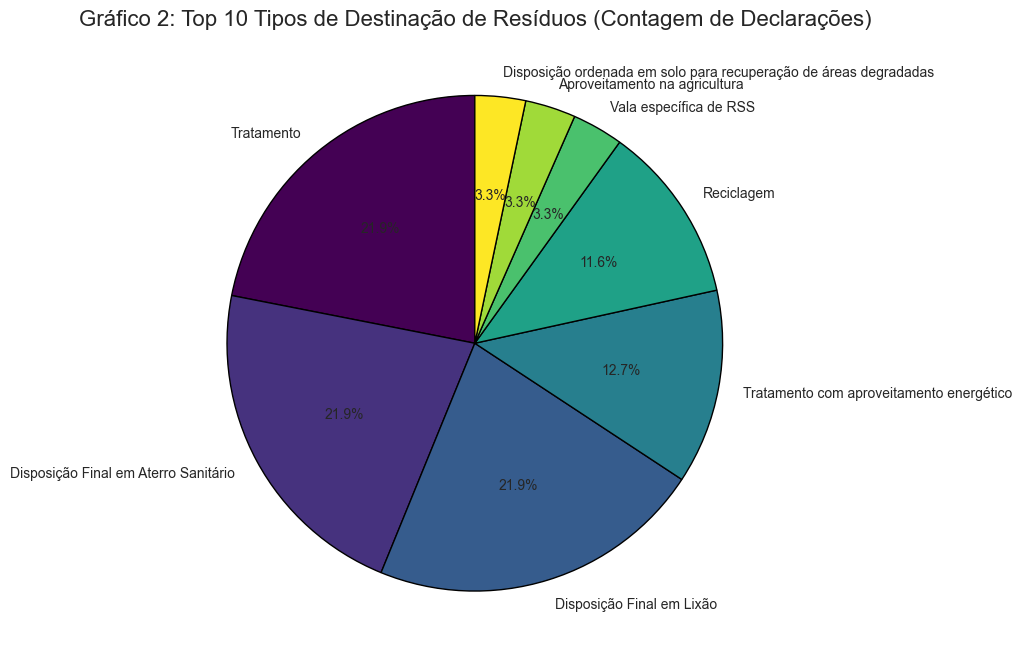

In [10]:
# Gráfico 2: Top 10 Tipos de Destinação de Resíduos (Contagem de Declarações)
destinacoes_validas = df['Destinacao'].dropna().str.strip()
top_destinacoes = destinacoes_validas.value_counts().nlargest(10)

cmap = plt.get_cmap('viridis', len(top_destinacoes))
colors = [cmap(i) for i in range(cmap.N)]

plt.figure(figsize=(10, 10))
plt.pie(top_destinacoes, labels=top_destinacoes.index, autopct='%1.1f%%', startangle=90, wedgeprops={'edgecolor': 'black', 'linewidth': 1}, colors=colors)
plt.title('Gráfico 2: Top 10 Tipos de Destinação de Resíduos (Contagem de Declarações)', fontsize=16)
plt.tight_layout()
plt.show()
plt.close()

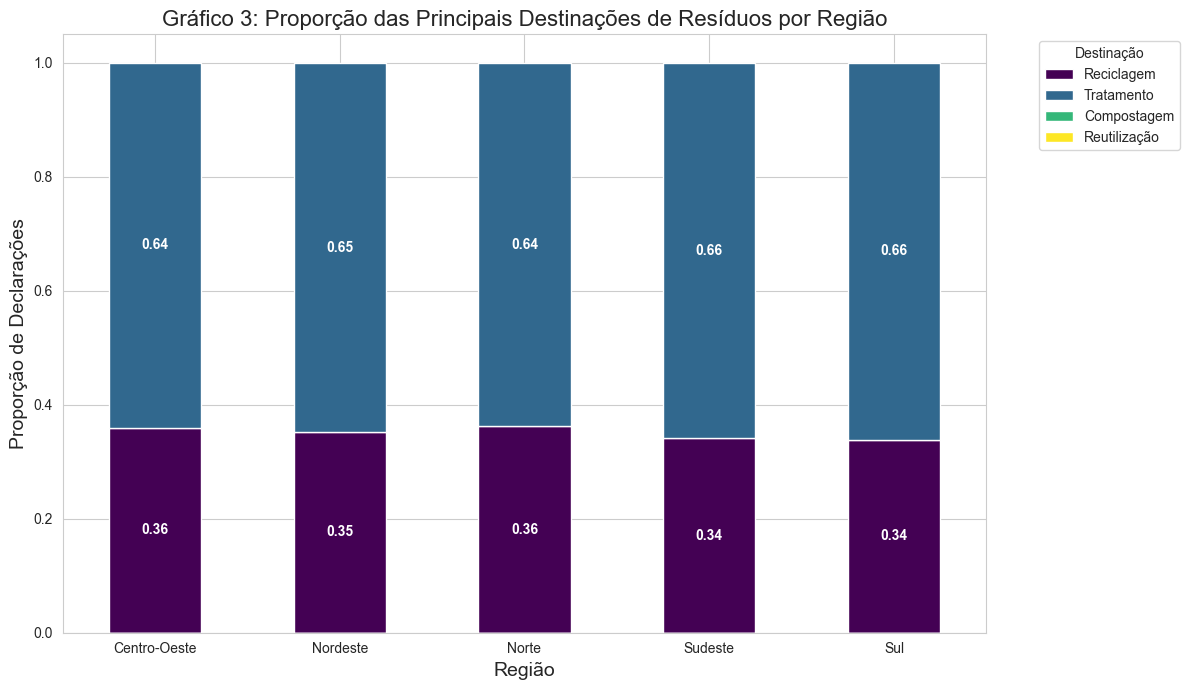

In [5]:
# Gráfico 3: Proporção das Principais Destinações de Resíduos por Região
regioes_map = {
    'AC': 'Norte', 'AM': 'Norte', 'AP': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste', 'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}
df['Regiao'] = df['UF'].map(regioes_map)

principais_destinacoes = ['Reciclagem', 'Tratamento', 'Compostagem', 'Reutilização']
df_destinacao_regiao = df[df['Destinacao'].isin(principais_destinacoes)]

destinacao_por_regiao = df_destinacao_regiao.groupby('Regiao')['Destinacao'].value_counts().unstack(fill_value=0)

destinacao_por_regiao = destinacao_por_regiao.reindex(columns=principais_destinacoes, fill_value=0)

denom = destinacao_por_regiao.sum(axis=1)
destinacao_por_regiao_norm = destinacao_por_regiao.div(denom.replace(0, 1), axis=0).fillna(0)

destinacao_por_regiao_norm.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis', ax=plt.gca())

for i, regiao in enumerate(destinacao_por_regiao_norm.index):
    acumulado = 0
    for destinacao in principais_destinacoes:
        proporcao = destinacao_por_regiao_norm.loc[regiao, destinacao]
        if proporcao > 0:
            plt.text(i, acumulado + proporcao / 2, f'{proporcao:.2f}', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
            acumulado += proporcao

plt.title('Gráfico 3: Proporção das Principais Destinações de Resíduos por Região', fontsize=16)
plt.xlabel('Região', fontsize=14)
plt.ylabel('Proporção de Declarações', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Destinação', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.close()

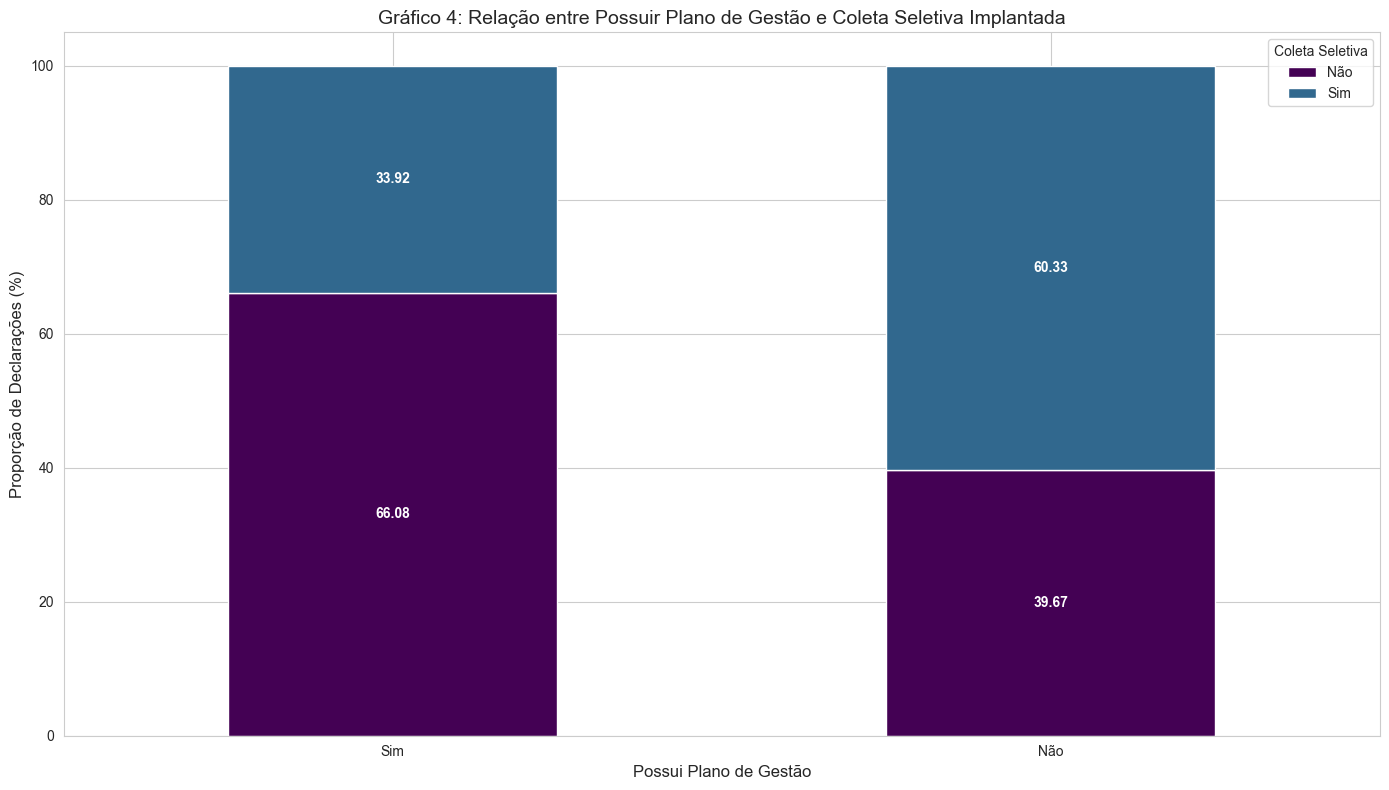

In [6]:
# Gráfico 4: Relação entre Possuir Plano de Gestão e Coleta Seletiva Implantada
cross_tab = pd.crosstab(df['Plano de Gestao'], df['Coleta Seletiva'], normalize='index') * 100
cross_tab = cross_tab.reindex(['Sim', 'Não'])

plt.figure(figsize=(14, 8))
ax = cross_tab[['Sim', 'Não']].plot(
    kind='bar', 
    stacked=True, 
    color=['#440154', '#31688E'], 
    ax=plt.gca()
)

for i in range(len(cross_tab)):
    sim_count = cross_tab['Sim'].iloc[i]
    nao_count = cross_tab['Não'].iloc[i]
    
    sim_count = round(sim_count, 2)
    nao_count = round(nao_count, 2)
    ax.text(i, sim_count / 2, str(sim_count), ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    ax.text(i, sim_count + (nao_count / 2), str(nao_count), ha='center', va='center', color='white', fontsize=10, fontweight='bold')

plt.title('Gráfico 4: Relação entre Possuir Plano de Gestão e Coleta Seletiva Implantada', fontsize=14)
plt.xlabel('Possui Plano de Gestão', fontsize=12)
plt.ylabel('Proporção de Declarações (%)', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Coleta Seletiva', labels=['Não', 'Sim'], loc='upper right')
plt.tight_layout()
plt.show()
plt.close()

C:\Users\matheusmakita-ieg\AppData\Local\Temp\ipykernel_39184\576333221.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_residuos.values, y=top_residuos.index, palette='viridis', orient='h', ax=plt.gca())


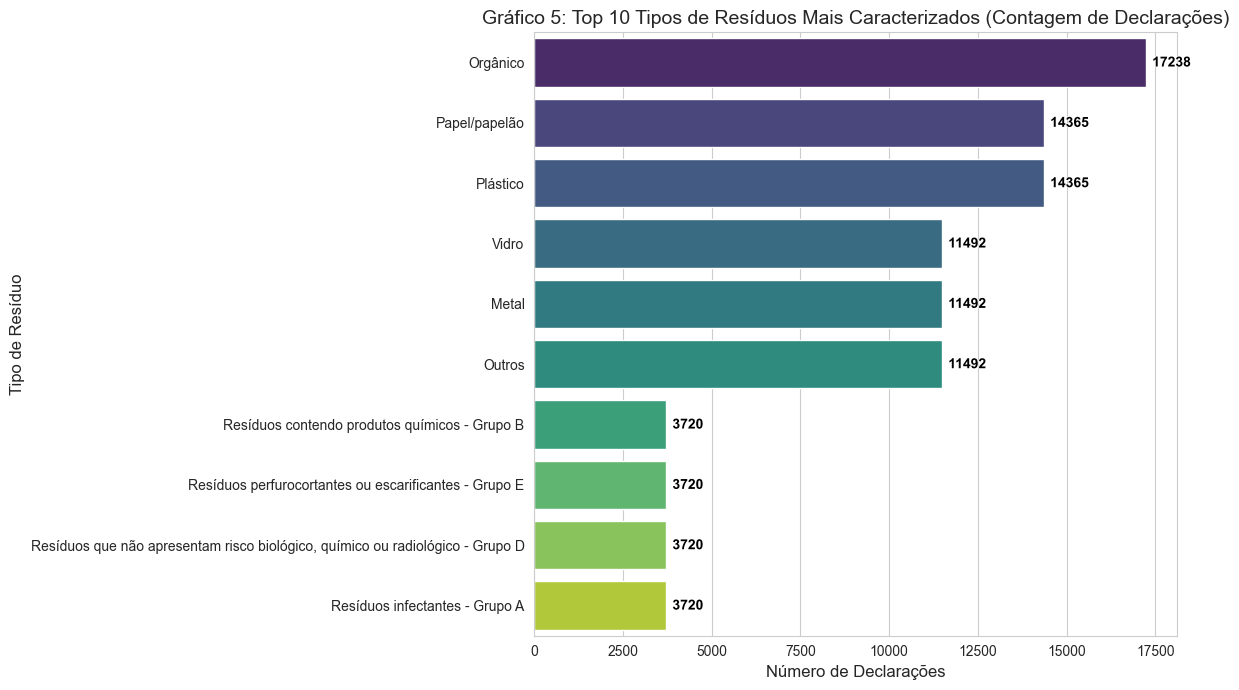

In [7]:
# Gráfico 5: Top 10 Tipos de Resíduos Mais Caracterizados (Contagem de Declarações)
top_residuos = df['Tipo Resíduo'].value_counts().nlargest(10)

plt.figure(figsize=(12, 7))
ax = sns.barplot(x=top_residuos.values, y=top_residuos.index, palette='viridis', orient='h', ax=plt.gca())

max_val = top_residuos.values.max() if len(top_residuos) > 0 else 0
offset = max_val * 0.01 
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.text(width + offset, y, f'{int(width)}', ha='left', va='center',
            fontsize=10, fontweight='bold', color='black',
            path_effects=[path_effects.withStroke(linewidth=1, foreground='white')])

plt.title('Gráfico 5: Top 10 Tipos de Resíduos Mais Caracterizados (Contagem de Declarações)', fontsize=14)
plt.xlabel('Número de Declarações', fontsize=12)
plt.ylabel('Tipo de Resíduo', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

# Relatório Final da Análise Exploratória de Dados | BASE SINIR: Diagnóstico Municipal de Resíduos Sólidos

Este relatório apresenta uma análise exploratória dos dados relacionados à gestão e destinação de resíduos no Brasil, com foco em identificar padrões, oportunidades e desafios para o desenvolvimento de soluções inteligentes de descarte e reaproveitamento de materiais.

## Gráfico 1 – Distribuição de Municípios com Coleta Seletiva Implantada por UF

**Descrição:**  
O gráfico mostra a quantidade de municípios com e sem coleta seletiva implantada, agrupados por Unidade Federativa (UF).

**Principais insights:**
- Estados como São Paulo (SP) e Minas Gerais (MG) se destacam pelo maior número absoluto de municípios com coleta seletiva.
- Em contraste, estados do Norte e Nordeste apresentam uma predominância de municípios sem coleta seletiva.
- Essa desigualdade regional revela grandes oportunidades de expansão de políticas públicas e soluções privadas voltadas à gestão de resíduos.

**Implicação para o app:**  
Estados com baixa implantação representam mercados promissores para a implementação de soluções tecnológicas de coleta inteligente e conscientização ambiental.

## Gráfico 2 – Top 10 Tipos de Destinação de Resíduos (Contagem de Declarações)

**Descrição:**  
O gráfico apresenta os principais tipos de destinação de resíduos, considerando a frequência das declarações.

**Principais insights:**
- As destinações mais comuns são Tratamento, Aterro Sanitário e Lixão, demonstrando que parte significativa dos resíduos ainda é descartada de forma tradicional.
- Reciclagem aparece apenas na quinta posição, evidenciando baixo aproveitamento dos materiais recicláveis.
- O tratamento com aproveitamento energético é uma alternativa crescente, mas ainda limitada.

**Implicação para o app:**  
Há um espaço expressivo para soluções que incentivem a reciclagem e conectem geradores de resíduos a compradores (marketplace circular).

## Gráfico 3 – Proporção de Reciclagem e Tratamento na Destinação por Região

**Descrição:**  
Mostra a proporção entre reciclagem e tratamento de resíduos em cada região brasileira.

**Principais insights:**
- As proporções são semelhantes entre as regiões, com predominância do tratamento sobre a reciclagem.
- Mesmo regiões com estrutura mais avançada (como Sul e Sudeste) mantêm uma baixa proporção de reciclagem efetiva.

**Implicação para o app:**  
Oportunidade para ampliar a reciclagem regionalmente e criar redes logísticas inteligentes que conectem cooperativas, empresas e consumidores.

## Gráfico 4 – Relação entre Plano de Gestão e Coleta Seletiva Implantada

**Descrição:**  
Analisa a correlação entre posse de plano de gestão de resíduos e implantação da coleta seletiva.

**Principais insights:**
- Municípios que possuem plano de gestão apresentam maior taxa de implantação da coleta seletiva.
- A ausência de planejamento está associada a menor adesão a práticas sustentáveis.

**Implicação para o app:**  
Municípios com planos ativos podem ser parceiros estratégicos para adoção do app e integração com sistemas públicos de coleta inteligente.

## Gráfico 5 – Top 10 Tipos de Resíduos Mais Caracterizados

**Descrição:**  
Apresenta os tipos de resíduos mais frequentemente declarados e caracterizados.

**Principais insights:**
- Resíduos orgânicos, papel/papelão e plástico lideram a lista, seguidos de vidro e metal.
- A presença significativa de resíduos recicláveis reforça o potencial de reaproveitamento.
- Há também volume relevante de resíduos perigosos (grupos A, B, D e E), indicando necessidade de descarte especializado.

**Implicação para o app:**  
O marketplace pode priorizar categorias com maior volume e valor de reaproveitamento (como plásticos, metais e papel), além de educar sobre o descarte seguro de resíduos perigosos.

## Conclusão Geral
A análise evidencia um cenário cheio de oportunidades para inovação na gestão de resíduos no Brasil:

- Grandes disparidades regionais na coleta seletiva.
- Predominância de destinações pouco sustentáveis.
- Baixo índice de reciclagem, mesmo em regiões desenvolvidas.
- Forte correlação entre planejamento municipal e desempenho ambiental.